# Topic Models

In [1]:
import pandas as pd

In [4]:
!ls ../data/


IT.it.json           reviews.full.tsv     sa_test.csv
UK.en.json           reviews.full.tsv.zip sa_train.csv
moby_dick.txt        reviews.xlsx         tweets_en.txt


In [2]:
df = pd.read_csv('../data/reviews.full.tsv', encoding='utf8', sep='\t')
len(df)

117075

In [3]:
df.head()

,score,category,uid,gender,age,text
0,5,Car Rental,899881,F,50,Prices change daily and if you want to really ...
1,5,Fitness & Nutrition,828184,M,32,and the fact that they will match other compan...
2,5,Electronic Payment,1698375,M,48,Used Paypal for my buying and selling for the ...
3,5,Gaming,3324079,M,29,I ' ve made two purchases on CJ ' s for Fallou...
4,4,Jewelry,719816,F,29,I was very happy with the diamond that I order...


In [ ]:
# import spacy
# nlp = spacy.load('en')
# def clean(text):
#     return ' '.join([token.lemma_ 
#             for token in nlp(text) 
#             if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X'}])

# clean('Here is an example test of it for me.')

# df['clean_text'] = df.text.apply(clean)

# df.to_csv('../data/reviews.full.tsv', encoding='utf8', sep='\t')

In [5]:
df = pd.read_excel('../data/reviews.xlsx', encoding='utf8')
df = df[df['clean_text'].notnull()]

In [6]:
len(df), df.head()

(434207,    Unnamed: 0                category  \
 0           0     Beauty and Wellness   
 1           1  Computer & Accessories   
 2           2                Bathroom   
 3           3    Cell phone Recycling   
 4           4                 Flowers   
 
                                                 text  \
 0  there was an issue with the delivery but this ...   
 1  i found the item i was looking for quickly on ...   
 2  part ordered monday pm and received it next day .   
 3  the day the phone was received i had the money...   
 4  flowers were beautiful , delivered on time and...   
 
                                           clean_text  
 0  issue delivery resolve quickly complete care s...  
 1  find item look quickly web site place order to...  
 2                        order monday pm receive day  
 3                       day phone receive money bank  
 4  flower beautiful deliver time notify progress ...  )

## LDA

In [10]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
import time # to know how long training took
import multiprocessing # to speed things up by parallelizing

In [8]:
# get dictionary
df['clean_text'] = df.clean_text.apply(str)
instances = df.clean_text.apply(str.split)[:50000]
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=100, no_above=0.1)
print(dictionary, flush=True)

creating dictionary
Dictionary(857 unique tokens: ['care', 'complete', 'issue', 'quickly', 'resolve']...)


In [9]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [139]:
instances[0], ldacorpus[0], model_corpus[0]

(['issue',
  'delivery',
  'resolve',
  'quickly',
  'complete',
  'care',
  'shop',
  'aware'],
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
 [(0, 0.4457031820155911),
  (1, 0.39113963122146483),
  (2, 0.41818224505518475),
  (3, 0.26389437830840706),
  (4, 0.5461271067643223),
  (5, 0.324941552750904)])

## Choosing the number of topics

In [25]:
coherence_values = []
model_list = []
for num_topics in range(5, 21):
    print(num_topics)
    model = LdaMulticore(corpus=model_corpus[:5000], id2word=dictionary, num_topics=num_topics)
    model_list.append(model)
    coherencemodel_umass = CoherenceModel(model=model, texts=instances[:5000], dictionary=dictionary, coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, texts=instances[:5000], dictionary=dictionary, coherence='c_v')

    coherence_values.append((num_topics, coherencemodel_umass.get_coherence(), coherencemodel_cv.get_coherence()))

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


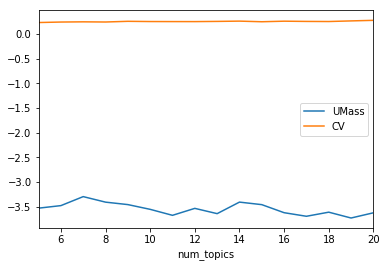

In [26]:
%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
scores.plot.line(x='num_topics')
# import matplotlib.pyplot as plt
# limit=20; start=5; step=1;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score_u_mass")
# plt.legend(("coherence_values"), loc='best')
# plt.grid()
# plt.show()

In [165]:
num_topics = 7

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5
                    )
    
print("done in {}".format(time.time()-start), flush=True)


2500.0
fitting model


INFO:gensim.models.ldamodel:using symmetric eta at 0.1
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamulticore:running online LDA training, 10 topics, 10 passes over the supplied corpus of 50000 documents, updating every 17500 documents, evaluating every ~50000 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamulticore:training LDA model using 7 processes
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2500/50000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #5000/50000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #7500/50000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #10000/50000, outstanding queue size 4
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispat

INFO:gensim.models.ldamodel:topic #1 (0.500): 0.011*"fast" + 0.009*"product" + 0.008*"flower" + 0.008*"website" + 0.007*"pay" + 0.007*"money" + 0.007*"excellent" + 0.007*"tyre" + 0.007*"company" + 0.007*"get"
INFO:gensim.models.ldamodel:topic #3 (0.500): 0.010*"product" + 0.010*"tyre" + 0.009*"buy" + 0.009*"company" + 0.009*"money" + 0.008*"flower" + 0.008*"website" + 0.008*"fast" + 0.007*"quickly" + 0.007*"cheap"
INFO:gensim.models.ldamodel:topic #6 (0.500): 0.011*"excellent" + 0.009*"flower" + 0.009*"item" + 0.007*"product" + 0.007*"get" + 0.007*"cheap" + 0.007*"happy" + 0.007*"company" + 0.006*"look" + 0.006*"money"
INFO:gensim.models.ldamodel:topic #8 (0.500): 0.008*"money" + 0.007*"fast" + 0.007*"item" + 0.007*"excellent" + 0.007*"flower" + 0.007*"need" + 0.007*"product" + 0.007*"buy" + 0.007*"process" + 0.007*"thank"
INFO:gensim.models.ldamodel:topic diff=0.022815, rho=0.213201
INFO:gensim.models.ldamulticore:PROGRESS: pass 1, dispatched chunk #10 = documents up to #27500/50000, 

INFO:gensim.models.ldamodel:topic #1 (0.500): 0.011*"fast" + 0.009*"product" + 0.008*"pay" + 0.008*"flower" + 0.008*"website" + 0.007*"get" + 0.007*"money" + 0.007*"excellent" + 0.007*"company" + 0.006*"buy"
INFO:gensim.models.ldamodel:topic #5 (0.500): 0.014*"fast" + 0.014*"tyre" + 0.008*"site" + 0.008*"website" + 0.008*"money" + 0.008*"product" + 0.008*"flower" + 0.007*"mobile" + 0.007*"company" + 0.007*"item"
INFO:gensim.models.ldamodel:topic #6 (0.500): 0.012*"excellent" + 0.010*"item" + 0.009*"flower" + 0.007*"cheap" + 0.007*"product" + 0.007*"get" + 0.007*"happy" + 0.007*"look" + 0.007*"company" + 0.006*"want"
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.014*"flower" + 0.011*"fast" + 0.009*"company" + 0.008*"website" + 0.008*"tyre" + 0.008*"product" + 0.008*"site" + 0.007*"quickly" + 0.007*"excellent" + 0.007*"buy"
INFO:gensim.models.ldamodel:topic #9 (0.500): 0.013*"money" + 0.012*"flower" + 0.010*"excellent" + 0.009*"mazuma" + 0.009*"post" + 0.009*"company" + 0.009*"tyre" + 

INFO:gensim.models.ldamodel:topic #5 (0.500): 0.017*"tyre" + 0.016*"fast" + 0.009*"mobile" + 0.009*"site" + 0.008*"fit" + 0.008*"website" + 0.007*"efficient" + 0.007*"product" + 0.007*"company" + 0.007*"money"
INFO:gensim.models.ldamodel:topic #7 (0.500): 0.017*"tyre" + 0.009*"excellent" + 0.009*"site" + 0.008*"customer" + 0.007*"get" + 0.007*"money" + 0.007*"website" + 0.006*"flower" + 0.006*"quality" + 0.006*"fit"
INFO:gensim.models.ldamodel:topic #6 (0.500): 0.012*"excellent" + 0.012*"item" + 0.009*"flower" + 0.008*"cheap" + 0.008*"happy" + 0.007*"look" + 0.007*"get" + 0.007*"product" + 0.006*"company" + 0.006*"want"
INFO:gensim.models.ldamodel:topic diff=0.045771, rho=0.204124
INFO:gensim.models.ldamodel:-7.358 per-word bound, 164.0 perplexity estimate based on a held-out corpus of 2500 documents with 6704 words
INFO:gensim.models.ldamulticore:PROGRESS: pass 4, dispatched chunk #0 = documents up to #2500/50000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass

INFO:gensim.models.ldamulticore:PROGRESS: pass 5, dispatched chunk #9 = documents up to #25000/50000, outstanding queue size 4
INFO:gensim.models.ldamodel:merging changes from 17500 documents into a model of 50000 documents
INFO:gensim.models.ldamodel:topic #7 (0.500): 0.024*"tyre" + 0.009*"excellent" + 0.009*"site" + 0.009*"customer" + 0.008*"fit" + 0.008*"garage" + 0.008*"get" + 0.007*"website" + 0.007*"helpful" + 0.007*"go"
INFO:gensim.models.ldamodel:topic #8 (0.500): 0.017*"memory" + 0.013*"shower" + 0.010*"thank" + 0.010*"need" + 0.008*"buy" + 0.008*"item" + 0.007*"sunglass" + 0.007*"process" + 0.006*"excellent" + 0.006*"fast"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.013*"fast" + 0.011*"pay" + 0.010*"line" + 0.008*"website" + 0.008*"process" + 0.008*"product" + 0.008*"get" + 0.007*"start" + 0.007*"flower" + 0.007*"finish"
INFO:gensim.models.ldamodel:topic #3 (0.500): 0.012*"vet" + 0.012*"buy" + 0.011*"cheap" + 0.011*"viovet" + 0.010*"money" + 0.010*"product" + 0.010*"compa

INFO:gensim.models.ldamulticore:PROGRESS: pass 6, dispatched chunk #15 = documents up to #40000/50000, outstanding queue size 4
INFO:gensim.models.ldamodel:merging changes from 17500 documents into a model of 50000 documents
INFO:gensim.models.ldamodel:topic #7 (0.500): 0.034*"tyre" + 0.011*"fit" + 0.010*"garage" + 0.009*"customer" + 0.009*"site" + 0.009*"excellent" + 0.008*"shopper" + 0.008*"helpful" + 0.008*"fitting" + 0.008*"go"
INFO:gensim.models.ldamodel:topic #8 (0.500): 0.022*"memory" + 0.017*"shower" + 0.012*"thank" + 0.012*"need" + 0.010*"sunglass" + 0.009*"buy" + 0.008*"work" + 0.007*"item" + 0.007*"upgrade" + 0.007*"expect"
INFO:gensim.models.ldamodel:topic #9 (0.500): 0.028*"money" + 0.027*"post" + 0.025*"mazuma" + 0.021*"cheque" + 0.016*"account" + 0.015*"morning" + 0.015*"bank" + 0.014*"monday" + 0.012*"tuesday" + 0.012*"sell"
INFO:gensim.models.ldamodel:topic #4 (0.500): 0.029*"product" + 0.017*"excellent" + 0.013*"ve" + 0.013*"site" + 0.013*"friend" + 0.012*"direct" + 0

INFO:gensim.models.ldamodel:merging changes from 12500 documents into a model of 50000 documents
INFO:gensim.models.ldamodel:topic #3 (0.500): 0.020*"vet" + 0.018*"viovet" + 0.018*"cheap" + 0.017*"battery" + 0.016*"buy" + 0.015*"prompt" + 0.014*"prescription" + 0.011*"company" + 0.011*"free" + 0.010*"quickly"
INFO:gensim.models.ldamodel:topic #2 (0.500): 0.019*"fantastic" + 0.014*"product" + 0.012*"ordering" + 0.012*"promptly" + 0.011*"quality" + 0.009*"straight" + 0.009*"choice" + 0.009*"online" + 0.009*"be" + 0.009*"item"
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.046*"flower" + 0.012*"birthday" + 0.011*"serenata" + 0.011*"beautiful" + 0.009*"despatch" + 0.008*"company" + 0.008*"leave" + 0.008*"delight" + 0.008*"recipient" + 0.007*"describe"
INFO:gensim.models.ldamodel:topic #6 (0.500): 0.023*"item" + 0.013*"excellent" + 0.012*"return" + 0.011*"happy" + 0.010*"look" + 0.010*"stock" + 0.009*"week" + 0.009*"perfume" + 0.008*"want" + 0.008*"refund"
INFO:gensim.models.ldamodel:topic

done in 75.91227316856384


In [166]:
# transform the data into topic distros
topic_corpus = model[model_corpus]

topic_corpus[0]

[(0, 0.0744842),
 (1, 0.11779746),
 (2, 0.08835794),
 (3, 0.0741268),
 (4, 0.26101395),
 (5, 0.08430748),
 (6, 0.07680602),
 (7, 0.07441241),
 (8, 0.07621281),
 (9, 0.07248095)]

In [167]:
model.print_topics()

INFO:gensim.models.ldamodel:topic #0 (0.500): 0.060*"flower" + 0.016*"beautiful" + 0.014*"birthday" + 0.013*"serenata" + 0.011*"recipient" + 0.010*"leave" + 0.010*"despatch" + 0.009*"describe" + 0.009*"inform" + 0.008*"delight"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.019*"line" + 0.018*"start" + 0.017*"simple" + 0.016*"transaction" + 0.015*"process" + 0.015*"pay" + 0.015*"finish" + 0.015*"fast" + 0.013*"say" + 0.013*"update"
INFO:gensim.models.ldamodel:topic #2 (0.500): 0.024*"fantastic" + 0.017*"promptly" + 0.017*"ordering" + 0.015*"product" + 0.014*"choice" + 0.013*"straight" + 0.012*"dispatch" + 0.011*"chocolate" + 0.011*"quality" + 0.011*"be"
INFO:gensim.models.ldamodel:topic #3 (0.500): 0.024*"battery" + 0.023*"cheap" + 0.023*"vet" + 0.021*"viovet" + 0.020*"prompt" + 0.019*"buy" + 0.016*"prescription" + 0.015*"free" + 0.015*"dog" + 0.013*"company"
INFO:gensim.models.ldamodel:topic #4 (0.500): 0.045*"product" + 0.027*"excellent" + 0.021*"friend" + 0.020*"ve" + 0.018*"direct

[(0,
  '0.060*"flower" + 0.016*"beautiful" + 0.014*"birthday" + 0.013*"serenata" + 0.011*"recipient" + 0.010*"leave" + 0.010*"despatch" + 0.009*"describe" + 0.009*"inform" + 0.008*"delight"'),
 (1,
  '0.019*"line" + 0.018*"start" + 0.017*"simple" + 0.016*"transaction" + 0.015*"process" + 0.015*"pay" + 0.015*"finish" + 0.015*"fast" + 0.013*"say" + 0.013*"update"'),
 (2,
  '0.024*"fantastic" + 0.017*"promptly" + 0.017*"ordering" + 0.015*"product" + 0.014*"choice" + 0.013*"straight" + 0.012*"dispatch" + 0.011*"chocolate" + 0.011*"quality" + 0.011*"be"'),
 (3,
  '0.024*"battery" + 0.023*"cheap" + 0.023*"vet" + 0.021*"viovet" + 0.020*"prompt" + 0.019*"buy" + 0.016*"prescription" + 0.015*"free" + 0.015*"dog" + 0.013*"company"'),
 (4,
  '0.045*"product" + 0.027*"excellent" + 0.021*"friend" + 0.020*"ve" + 0.018*"direct" + 0.017*"site" + 0.017*"shop" + 0.015*"high" + 0.014*"quality" + 0.013*"chemist"'),
 (5,
  '0.037*"fast" + 0.026*"efficient" + 0.023*"friendly" + 0.021*"tyre" + 0.017*"competit

In [168]:
import re

# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

INFO:gensim.models.ldamodel:topic #0 (0.500): 0.060*"flower" + 0.016*"beautiful" + 0.014*"birthday" + 0.013*"serenata" + 0.011*"recipient"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.019*"line" + 0.018*"start" + 0.017*"simple" + 0.016*"transaction" + 0.015*"process"
INFO:gensim.models.ldamodel:topic #2 (0.500): 0.024*"fantastic" + 0.017*"promptly" + 0.017*"ordering" + 0.015*"product" + 0.014*"choice"
INFO:gensim.models.ldamodel:topic #3 (0.500): 0.024*"battery" + 0.023*"cheap" + 0.023*"vet" + 0.021*"viovet" + 0.020*"prompt"
INFO:gensim.models.ldamodel:topic #4 (0.500): 0.045*"product" + 0.027*"excellent" + 0.021*"friend" + 0.020*"ve" + 0.018*"direct"
INFO:gensim.models.ldamodel:topic #5 (0.500): 0.037*"fast" + 0.026*"efficient" + 0.023*"friendly" + 0.021*"tyre" + 0.017*"competitive"
INFO:gensim.models.ldamodel:topic #6 (0.500): 0.032*"item" + 0.016*"return" + 0.014*"stock" + 0.013*"happy" + 0.012*"look"
INFO:gensim.models.ldamodel:topic #7 (0.500): 0.052*"tyre" + 0.018*"fit" + 0.01

1 "flower", "beautiful", "birthday", "serenata", "recipient"
2 "line", "start", "simple", "transaction", "process"
3 "fantastic", "promptly", "ordering", "product", "choice"
4 "battery", "cheap", "vet", "viovet", "prompt"
5 "product", "excellent", "friend", "ve", "direct"
6 "fast", "efficient", "friendly", "tyre", "competitive"
7 "item", "return", "stock", "happy", "look"
8 "tyre", "fit", "fitting", "garage", "helpful"
9 "memory", "shower", "thank", "need", "sunglass"
10 "money", "mazuma", "post", "account", "cheque"


## Aggregating topics by a dependent variable

In [169]:
# get a list of all the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(50000)]
# turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
# add the review category of each document (so we can aggregate)
topic_distros['category'] = df.category[:50000]

In [170]:
topic_distros.head()

,"flower, beautiful","line, start","fantastic, promptly","battery, cheap","product, excellent","fast, efficient","item, return","tyre, fit","memory, shower","money, mazuma",category
0,0.074488,0.117650,0.088436,0.074128,0.261073,0.084308,0.076806,0.074414,0.076214,0.072483,Beauty and Wellness
1,0.108339,0.066147,0.070699,0.144679,0.081837,0.153755,0.099519,0.068955,0.136343,0.069726,Computer & Accessories
2,0.078475,0.078332,0.078362,0.078400,0.078360,0.078586,0.078560,0.078566,0.078389,0.293970,Bathroom
3,0.078310,0.079153,0.079078,0.081224,0.078643,0.078907,0.078618,0.078975,0.078702,0.288389,Cell phone Recycling
4,0.317548,0.083128,0.089971,0.071377,0.074113,0.070095,0.072348,0.076979,0.071463,0.072978,Flowers


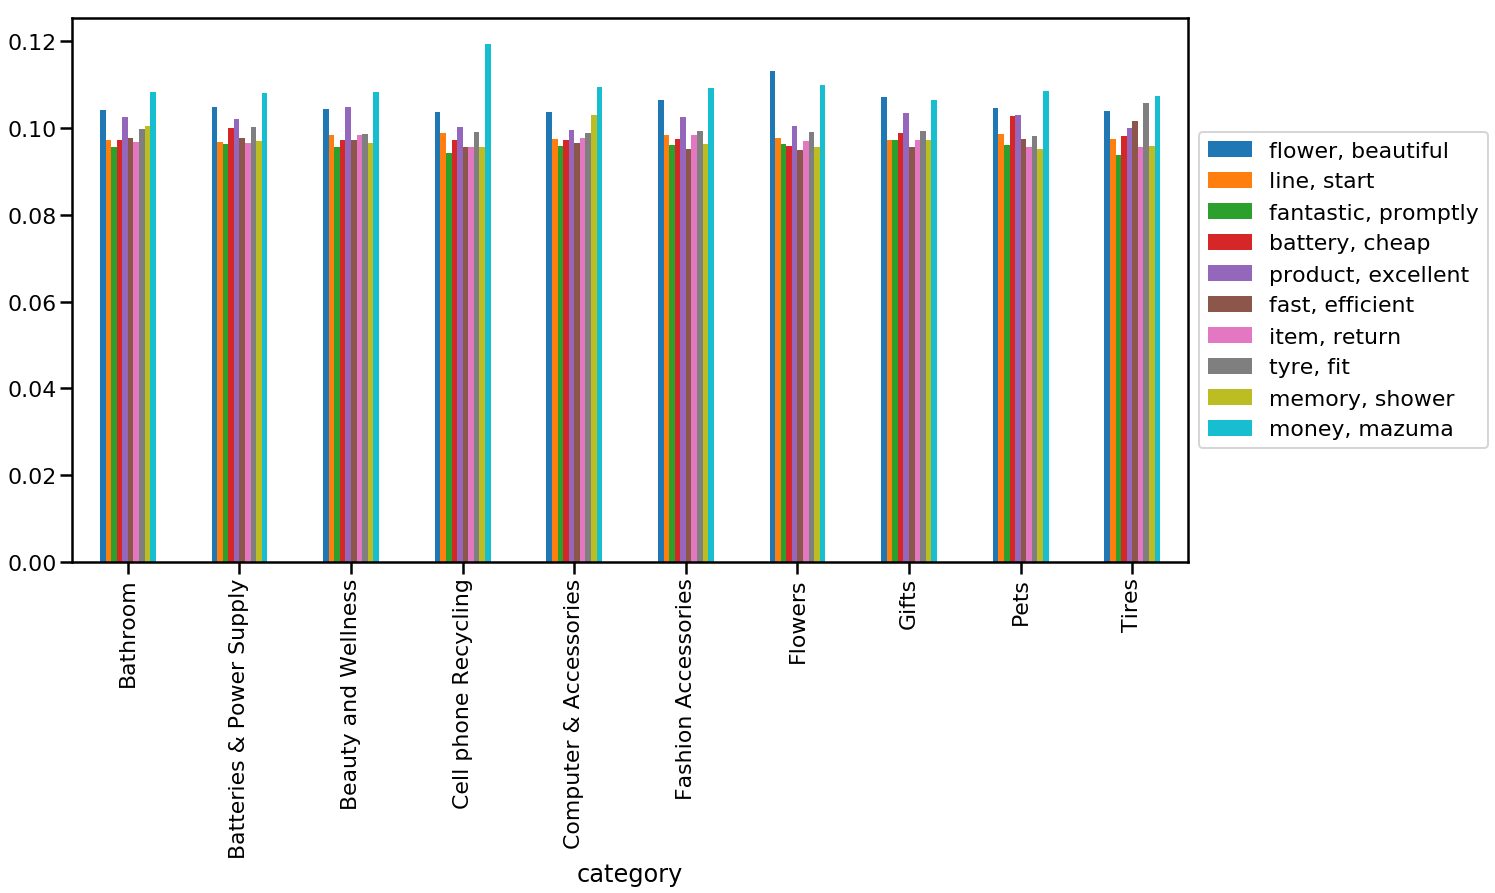

In [171]:
%matplotlib inline
import matplotlib.pyplot as plt # make graphs
import seaborn # make prettier graphs

seaborn.set_context('poster') # use large font

fig, ax = plt.subplots(figsize=(20, 10)) # set graph size
# aggregate topics by review categories
aggregate_by_category = topic_distros.groupby(topic_distros.category).mean()
# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax);
# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

# Guided LDA

In [104]:
import numpy as np
import guidedlda
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vectorize input
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,1), min_df=100, max_df=0.1, stop_words='english')
X = vectorizer.fit_transform(df.clean_text.tolist())

# store lookup structures for convenience
vocab = vectorizer.get_feature_names()
word2id = dict((v, idx) for idx, v in enumerate(vocab))

print(X.shape)

(434207, 2978)


In [105]:
# define topic seeds based on intuition
indicators = {
    'BATH': "bath,toilet,soap".split(','),
    'POWER': "battery,bank,plug".split(','), 
    'BEAUTY': "product,powder,cream".split(','),
    'PHONES': "phone,charger".split(','),
    'COMPUTER': "screen,keyboard,mouse".split(','),
    'FASHION': "trousers,shirt,skirt".split(','),
    'FLOWERS': "flower,color,smell,fresh".split(','),
    'GIFTS': "gift,present,give".split(','),
    'PETS': "dog,cat,leash,collar".split(','),
    'TIRES': "tire,tyre,wheel,car".split(',')
}

topic_names, seed_topic_list = zip(*indicators.items())
# filter out all words not actually in vocab
seed_topic_list = [[w for w in words if w in set(vocab)] for words in seed_topic_list]
    
# create a mapping {word_id: k}, which we need for the model
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id
        
print(seed_topic_list)

[['bath', 'toilet', 'soap'], ['battery', 'bank', 'plug'], ['product', 'powder', 'cream'], ['charger'], ['screen', 'keyboard', 'mouse'], ['shirt'], ['flower', 'color', 'smell', 'fresh'], ['gift', 'present'], ['dog', 'cat', 'collar'], ['tire', 'tyre', 'wheel', 'car']]


In [114]:
# define model
model = guidedlda.GuidedLDA(n_topics=len(seed_topic_list), n_iter=1000, random_state=7, refresh=50, alpha=0.5, eta=0.000001)

# fit the model with seeds
doc_topic = model.fit_transform(X[:50000], seed_topics=seed_topics, seed_confidence=10)

# retrieve the word descriptors
n_top_words = 5
topic_word = model.topic_word_
descriptors_guided = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: "{}"'.format(topic_names[i], '" "'.join(topic_words)))
    descriptors_guided.append('" "'.join(topic_words[:2]))

INFO:guidedlda:n_documents: 50000
INFO:guidedlda:vocab_size: 2978
INFO:guidedlda:n_words: 555013
INFO:guidedlda:n_topics: 10
INFO:guidedlda:n_iter: 1000
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:guidedlda:<0> log likelihood: -5519066
INFO:guidedlda:<50> log likelihood: -4074058
INFO:guidedlda:<100> log likelihood: -4043795
INFO:guidedlda:<150> log likelihood: -4032900
INFO:guidedlda:<200> log likelihood: -4026192
INFO:guidedlda:<250> log likelihood: -4020685
INFO:guidedlda:<300> log likelihood: -4016773
INFO:guidedlda:<350> log likelihood: -4016226
INFO:guidedlda:<400> log likelihood: -4014100
INFO:guidedlda:<450> log likelihood: -4013817
INFO:guidedlda:<500> log likelihood: -4010663
INFO:guidedlda:<550> log likeliho

Topic BATH: "email" "morning" "place" "monday" "hour"
Topic POWER: "money" "mazuma" "post" "account" "sell"
Topic BEAUTY: "product" "excellent" "fast" "company" "quality"
Topic PHONES: "site" "need" "website" "look" "web"
Topic COMPUTER: "company" "memory" "deal" "problem" "excellent"
Topic FASHION: "customer" "return" "week" "ask" "try"
Topic FLOWERS: "flower" "friend" "beautiful" "say" "thank"
Topic GIFTS: "look" "quality" "buy" "gift" "come"
Topic PETS: "cheap" "buy" "free" "vet" "dog"
Topic TIRES: "tyre" "fit" "work" "fitting" "car"


In [117]:
# get a list of all the topic scores for each document
# scores = [[t[1] for t in topic_corpus[entry]] for entry in range(50000)]
# turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
topic_distros_guided = pd.DataFrame(data=model.doc_topic_, columns=descriptors_guided)
# add the review category of each document (so we can aggregate)
topic_distros_guided['category'] = df.category[:50000]


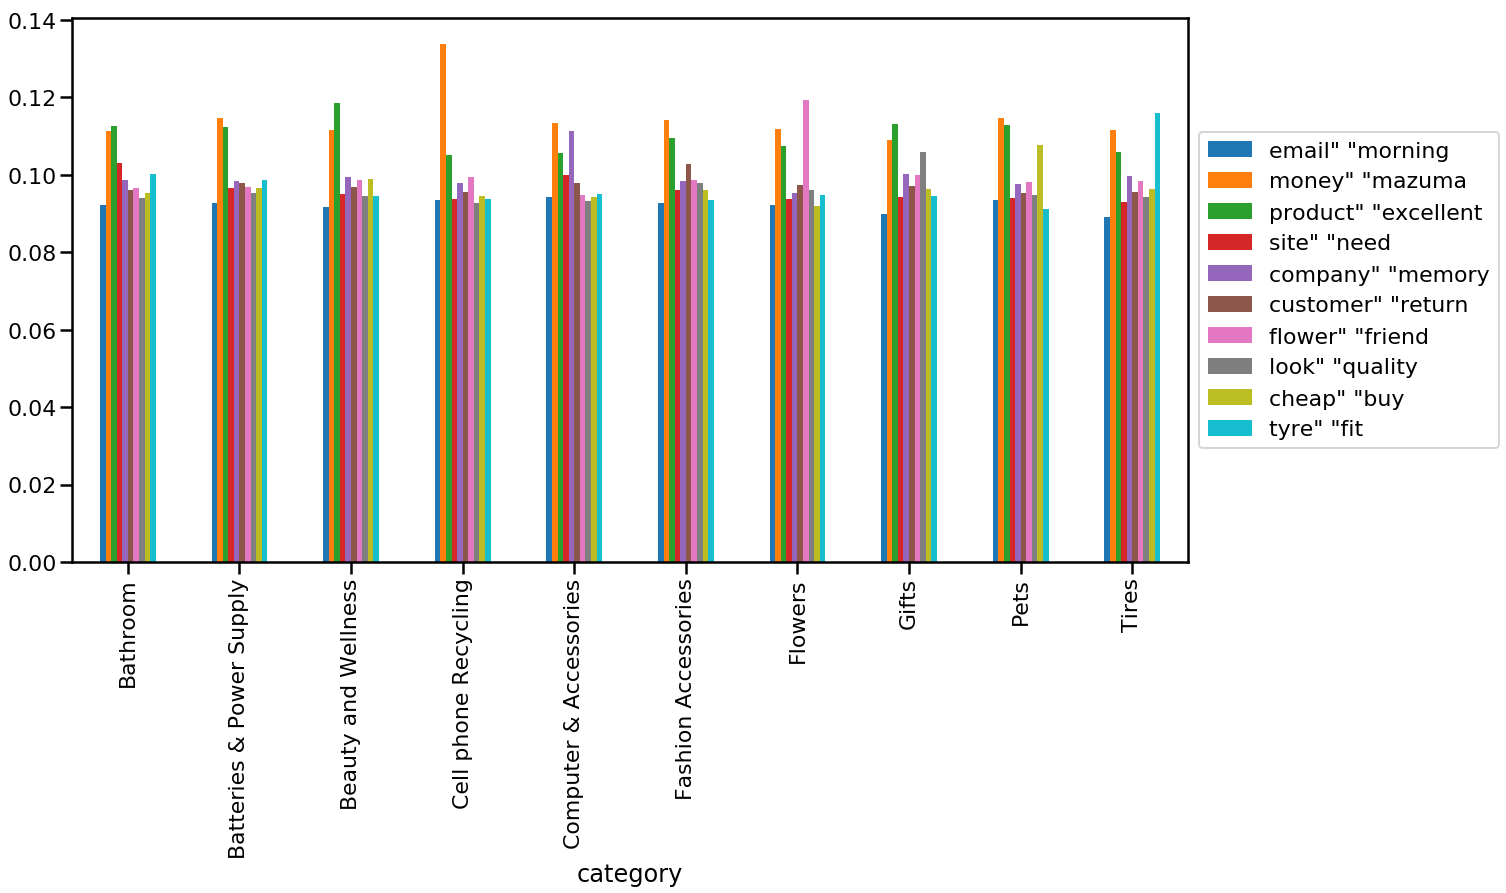

In [118]:
fig, ax = plt.subplots(figsize=(20, 10)) # set graph size
# aggregate topics by review categories
aggregate_by_category = topic_distros_guided.groupby(topic_distros_guided.category).mean()
# plot the graph
aggregate_by_category[descriptors_guided].plot.bar(ax=ax);
# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));